In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.applications import InceptionV3

2024-03-28 13:05:08.188283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 13:05:08.188377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 13:05:08.345237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

In [3]:
import os



# Get the list of class folders
class_folders = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

# Iterate through each class folder and count the number of images
for class_folder in class_folders:
    class_path = os.path.join(data_dir, class_folder)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_folder}, Number of Images: {num_images}")

Class: Mild, Number of Images: 370
Class: Proliferate_DR, Number of Images: 295
Class: Moderate, Number of Images: 999
Class: No_DR, Number of Images: 1805
Class: Severe, Number of Images: 193


In [4]:
Imagesize = 224


seed = 123

training_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(Imagesize,Imagesize),
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    subset='both',
    seed=seed )

Found 3662 files belonging to 5 classes.
Using 2930 files for training.
Using 732 files for validation.


(32, 224, 224, 3)


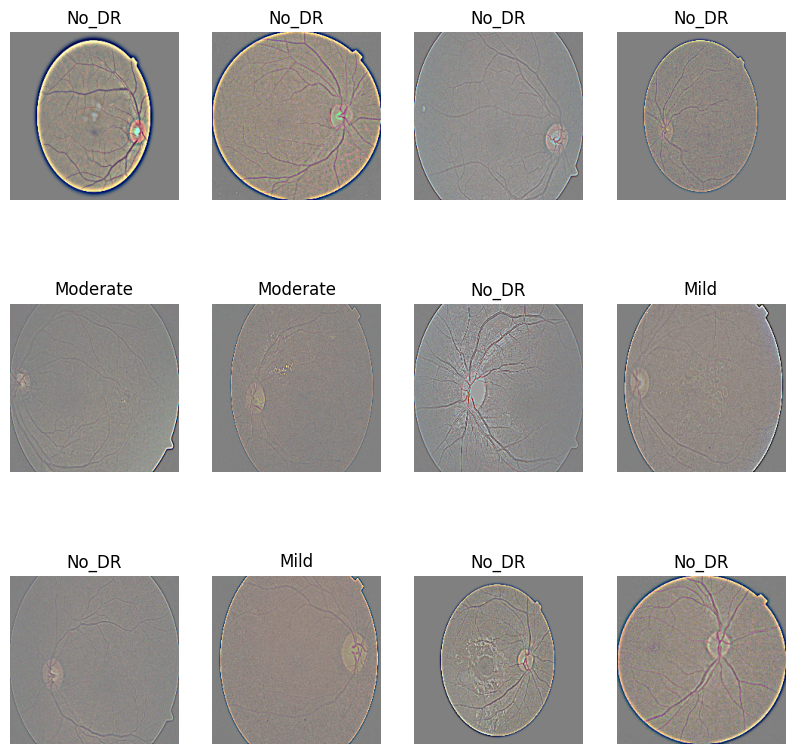

In [5]:
import matplotlib.pyplot as plt

for image_batch,label_batch in training_dataset.take(1):

  print(image_batch.shape)
  plt.figure(figsize=(10,10))
  for i in range (12):
    axs = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(training_dataset.class_names[label_batch[i]])
    plt.axis('off')

In [6]:
training_dataset = training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset =validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Imagesize ,Imagesize ),
    layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomContrast(0.1),
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(factor=0.2),
])

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
for layer in base_model.layers[:-5]:
    layer.trainable = False


In [10]:
model = models.Sequential()
model.add(resize_and_rescale)
model.add(data_augmentation)


In [11]:
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))


In [12]:
input  =  (32,224,224,3)
model.build(input_shape = input)
model.compile(optimizer = 'adam',
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy']
               )
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (32, 5, 5, 2048)       │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (32, 2048)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1024)             │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1024)             │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 512)              │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 128)              │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 32)               │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 5)                │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,545,317 (97.45 MB)

 Trainable params: 3,742,533 (14.28 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [13]:
record = model.fit(
    training_dataset,
    batch_size = 32,
    epochs = 50,
    validation_data = validation_dataset,
    verbose = 1,
    
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.5611 - loss: 1.1836 - val_accuracy: 0.6967 - val_loss: 0.9434
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.7224 - loss: 0.8169 - val_accuracy: 0.5820 - val_loss: 1.2344
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.7081 - loss: 0.8131 - val_accuracy: 0.7227 - val_loss: 0.7351
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.7387 - loss: 0.7489 - val_accuracy: 0.7131 - val_loss: 0.8307
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.7366 - loss: 0.7307 - val_accuracy: 0.7254 - val_loss: 0.7328
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.7365 - loss: 0.7467 - val_accuracy: 0.7199 - val_loss: 0.7477
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.7369 - loss: 0.7225 - val_accuracy: 0.7309 - val_loss: 0.7282
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.7464 - loss: 0.7077 - val_accu

In [16]:
from sklearn.metrics import classification_report
import numpy as np
# Predict labels for the validation dataset
y_pred = model.predict(validation_dataset)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels from the validation dataset
y_true = []
for images, labels in validation_dataset:
    y_true.extend(labels.numpy())

# Generate classification report
classification_metrics = classification_report(y_true, y_pred_classes)
print(classification_metrics)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
              precision    recall  f1-score   support

           0       0.52      0.32      0.39        76
           1       0.56      0.81      0.66       193
           2       0.97      0.94      0.96       369
           3       0.24      0.09      0.13        58
           4       0.26      0.19      0.22        36

    accuracy                           0.74       732
   macro avg       0.51      0.47      0.47       732
weighted avg       0.72      0.74      0.72       732

